# **Energy consumption measurement using RAPL Report**

**Course:** Complex IT Systems  
**Author:** Eray Erkul  
**Date:** 18 October 2025  

---

**References:**
Mostly code are used from the **"comparing samples from normal distrubution.ipynb"** and **"comparing two non-normal distrbutions by random sampling.ipynb"** on the moodle. The article, **"RAPL in Action: Experiences in Using RAPL for Power Measurements"** was also used.
"DETERMINATION OF SAMPLE SIZE AND SAMPLING METHODS IN APPLIED RESEARCH" - DOI:10.24874/PES03.01.003.

Lastly **AI** was also used to give an overview of my project and if i had missed something from the requirements. Few code was used with AI and modified by me to match with the needs i had. These places are noted as #AI as a comment next to the code.

## 1. Research questions and Hypothesis

## **1.1 Research Question**

**Overall Question:**  
Which software characteristic has the largest impact on energy consumption compared to CPU-intensive workloads?

**Precise Research Question:**  
Given equal execution time for both CPU and DRAM, do DRAM‑intensive workloads use less energy than CPU‑bound workloads, even with frequent memory accesses?

---

### **1.2 Hypotheses** 

**Null Hypothesis (H₀):**  
There is **no significant difference** in energy consumption between DRAM heavey workloads and CPU-bound workloads, when controlling for execution time.

**Alternative Hypothesis (H₁):**  
There is a **significant difference** in energy consumption. DRAM heavy workloads consume **less** energy than CPU-bound workloads, when controlling for execution time.

---

### **1.3 Variables**
**Independent variable:**  
The independent variable in this experiment is the stress tests for CPU and memory (DRAM). The memory stress code was adjusted to match the structure of the code used for the other classes.

**Dependent variable:**  
The dependent variable is the energy consumption that CPU and memory use during the test and is measured by using RAPL. 

**Choice of Dependent Variables**
Memory (DRAM) was chosen because it stores data temporarily while programs are running. It is fast and can use a lot of energy under load, but i believe it uses less energy than the CPU.

**Controlled variables:**
All tests are conducted under the following controlled conditions:
- Hardware: All test PCs use identical hardwares.
- Operating system: All PCs run the same Linux and version (Ubuntu Server 24.04 LTS).
- Power and services: Laptops are connected to AC power, and nonessential background services are disabled.
- Cooling and environment: Tests are done at similar device temperatures, on the same surface, and under similar surrounding conditions.

**Comfounding variables**:
- Outcome of the memory stress test has negative numbers.
- Small differences in temperature or how well the computer was cooled could have affected how much power the CPU or memory used.
- dbus service was not disabled and might have an affect.
---

## **2. Methodology**

In this experiment, we measure the energy consumption of CPU-intensive and DRAM-intensive workloads. To do this, we use Intel’s Running Average Power Limit (RAPL) feature, which measures accurate energy consumption data from the CPU. Stress-ng is used to run different workloads that simulate heavy CPU and memory usage. 
The experiment was conducted on a Dell Latitude laptop with the following specifications:

- Intel® Core™ i5-8350U @ 1.70GHz
- System Memory: 16 GiB RAM
- Storage: CA3-8D256-Q11 NVMe LITEON 256 GB
- Display: Intel UHD Graphics 620

All services were disabled during stress testing, although dbus could not be disabled.

To determine the sample size for the experiment, Cochran’s formula is applied: $n = \frac{Z^2 * p * q}{e^2}$
- Z is the Z-score i.e conffidence level. (For a 95% confidence interval, the Z-score from the standard normal distribution is 1.96.)
- p is the estimated proportion of the population. (Since we do not have prior information about the data, we use 0.5 as a conservative estimate.)
- q is 1 - p
- and e is the Desired margin of error (precision). (A value of 0.05 means the result should be within 5% of the actual population.)

Cochran’s sample size formula helps researchers figure out how many participants or data points are needed for a study. 
For this study, a 95% confidence level will be used.

In [8]:
z = 1.96
p = 0.5
q = 1 - p
e = 0.05

n = (z**2 * p * q)/e**2
print(f"Calculated sample size for the study: {n}")

Calculated sample size for the study: 384.1599999999999


Each stress test has been run 400 times with a 20 seconds timeout per run. Based on Cochran's formula, at least 384 runs were required to ensure the sample size was large enough for a reliable analysis.

KOM IND PÅ EXPERIMENTAL SETUP OG CONTROLLED SETUP

The stress test results are saved in a CSV file. Only the energy consumption measurements of the CPU and the whole package (PKG) are included. Measurements from NN and NN2 are excluded.

To whether accept or reject the null hypotheses, I must perform a statistical analysis

In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import random

Before starting to work on the data, i need to make sure the data formatation is correct, for that i need to change the ';' into a ','. To do this, using sep= will do the job.

In [14]:
data_CPU = pd.read_csv('../Data/cpu-stress-ng.csv', sep=r'[;,\s]+', engine='python', names=['test','PKG','CPU','time']) #AI was used here i.e. AI added sep=r'[;,\s]+', engine='python'
data_CPU

,test,PKG,CPU,time
0,cpu,780.842224,749.859436,20296.5
1,cpu,479.237854,450.172913,20398.4
2,cpu,445.622253,418.648560,20244.8
3,cpu,447.585815,415.841675,20418.0
4,cpu,447.605896,416.566711,20353.9
...,...,...,...,...
395,cpu,386.230713,353.864685,20516.5
396,cpu,373.332092,342.597961,20320.0
397,cpu,382.693298,351.696472,20525.8
398,cpu,388.489990,356.199036,20552.2


In [15]:
data_memory = pd.read_csv('../Data/memory-stress-ng.csv', sep=r'[;,\s]+', engine='python', names=['test','PKG','CPU','time'])
data_memory

,test,PKG,CPU,time
0,memory,484.963074,423.709290,23240.3
1,memory,446.409363,383.956543,23038.3
2,memory,468.358276,407.212402,23149.1
3,memory,468.924866,405.436584,23085.6
4,memory,483.161377,423.068176,23133.6
...,...,...,...,...
395,memory,439.955383,371.022034,23800.9
396,memory,239.430481,183.562012,23779.2
397,memory,420.123962,358.072510,22604.3
398,memory,448.154541,381.284973,23190.3


Then i will combine both dataframeworks by using merge (outer function).

In [19]:
concat_two_frameworks = pd.merge(data_CPU, data_memory, on='test', how='outer' )

concat_two_frameworks['PKG'] = concat_two_frameworks['PKG_x'].combine_first(concat_two_frameworks['PKG_y'])
concat_two_frameworks['CPU'] = concat_two_frameworks['CPU_x'].combine_first(concat_two_frameworks['CPU_y'])
concat_two_frameworks['time']= concat_two_frameworks['time_x'].combine_first(concat_two_frameworks['time_y'])

combined_df = concat_two_frameworks[['test','PKG','CPU','time']]
combined_df

,test,PKG,CPU,time
0,cpu,780.842224,749.859436,20296.5
1,cpu,479.237854,450.172913,20398.4
2,cpu,445.622253,418.648560,20244.8
3,cpu,447.585815,415.841675,20418.0
4,cpu,447.605896,416.566711,20353.9
...,...,...,...,...
795,memory,439.955383,371.022034,23800.9
796,memory,239.430481,183.562012,23779.2
797,memory,420.123962,358.072510,22604.3
798,memory,448.154541,381.284973,23190.3


To get an overview about the data we can use describe() and make some plots about the data.

In [21]:
combined_df.describe()

,PKG,CPU,time
count,800.000000,800.000000,800.000000
mean,75.523317,27.739339,21936.753000
std,9276.013416,9266.708860,1710.199352
min,-261955.759705,-261740.741150,20213.000000
25%,384.326294,351.949402,20331.075000
50%,397.559082,362.471436,21291.100000
75%,447.528870,388.768463,23303.325000
max,780.842224,749.859436,28488.300000


<Axes: xlabel='CPU', ylabel='time'>

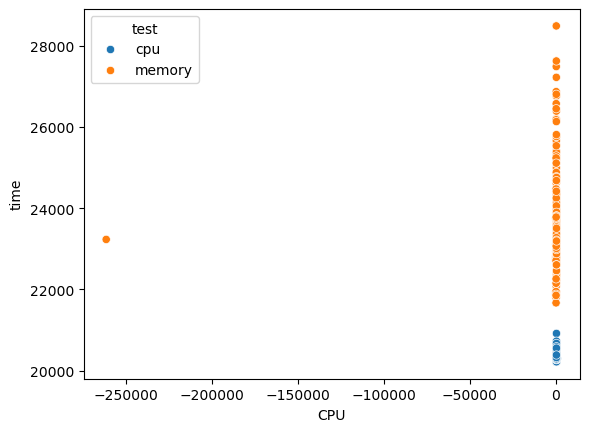

In [20]:
sns.scatterplot(data=combined_df,hue='test',x='CPU', y='time')

<Axes: xlabel='PKG', ylabel='time'>

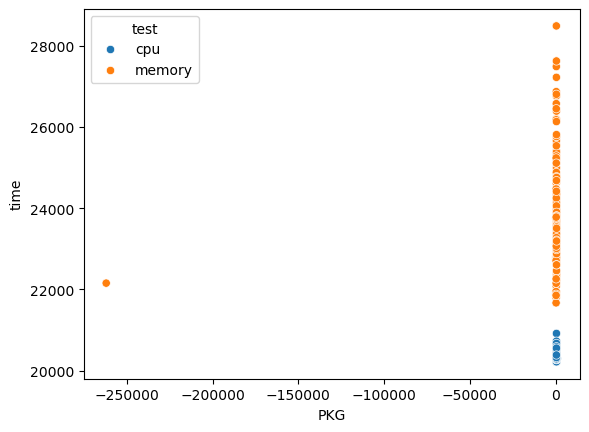

In [22]:
sns.scatterplot(data=combined_df,hue='test',x='PKG', y='time')

<Axes: xlabel='CPU', ylabel='Count'>

C:\Users\eray2\AppData\Roaming\Python\Python313\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\eray2\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


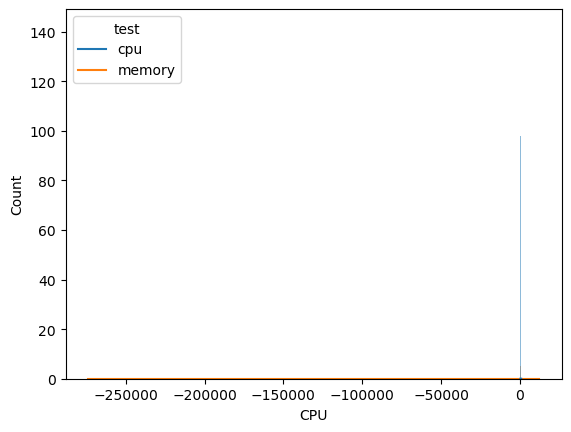

In [23]:
sns.histplot(data=combined_df,hue='test',x='CPU')
sns.kdeplot(data=combined_df,hue='test',x='CPU')

I can see on the mean and scatterplot that there are negative numbers, so they must be removed.
I will check for which group has negative values.

In [ ]:
for col in ['PKG', 'CPU', 'time']:
    any_negatives = (data_CPU[col] < 0).any()
    print(f"Any negatives in '{col}'? {any_negatives}")

Any negatives in 'PKG'? True
Any negatives in 'CPU'? True
Any negatives in 'time'? False


In [27]:
for col in ['PKG', 'CPU', 'time']:
    any_negatives = (data_memory[col] < 0).any()
    print(f"Any negatives in '{col}'? {any_negatives}")

Any negatives in 'PKG'? True
Any negatives in 'CPU'? True
Any negatives in 'time'? False


Both groups have negative numbers.

In [28]:
for col in ['PKG', 'CPU', 'time']:
    any_negatives = (combined_df[col] < 0).any()
    print(f"Any negatives in '{col}'? {any_negatives}")

Any negatives in 'PKG'? True
Any negatives in 'CPU'? True
Any negatives in 'time'? False


And the overall combined dataframe do of course also have negative numbers

First i will check if my data is normal distributed or not. To do so, i will first check for not a number (NaN), negative values, and any outliers, if having some, they must be removed.

In [25]:
combined_df.isna().sum()

test    0
PKG     0
CPU     0
time    0
dtype: int64